# Fluid and structure operators test

In [1]:
include("../src/FSI.jl")
using FSI

In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

## <span style="color:blue"> Set up rigid body with Dyn3d

#### Include any joint-body setup script from Dyn3d

In [3]:
include(Pkg.dir("Dyn3d")*"/src/config_files/2dFall.jl")

Config info set up.


#### Build joint-body chain

In [4]:
bs, js, bsys = BuildChain(config_bodys, config_joints, config_system)
bd = BodyDyn(bs, js, bsys)

This is a 1 body-joint system, system is fixed in space

#### Initialize rigid body system state to complete body-joint information

In [5]:
bd, soln₀ = InitSystem!(bd)

(, Dyn3d.ConstructSystem.Soln{Float64}(0.0, 0.001, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float64[], Float64[]))

This is a 1 body-joint system, system is fixed in space

#### Initialize u and λ container

In [6]:
@get bd (bs, js, sys)

qJ_dim = sys.ndof
λ_dim = sys.ncdof_HERK
u = zeros(qJ_dim)
λ = zeros(λ_dim);

#### Get body verts for plotting

In [7]:
bs, js, sys = UpdatePosition!(bs, js, sys, soln₀.qJ)
vs₀ = VertsHistory(sys.nbody, bs);

#### Plot body only

In [8]:
# p = plot()
# for i = 1:sys.nbody
#     plot!(p,vs₀[i,2:3,1], vs₀[i,2:3,2],linewidth=2)
# end
# plot!(xlims=(0,3), ylims=(0,2))

## <span style="color:blue"> Set up fluid with Whirl </span>

#### Set the flow parameters

In [9]:
Re = 200 # Reynolds number
U = 1.0 # Free stream velocity
U∞ = (U, 0.0)

(1.0, 0.0)

#### Set the domain grid

In [10]:
nx = 152; ny = 102;
Ly = 2.0;
Δx = Ly/(ny-2);
w₀ = Nodes(Dual,(nx,ny))
xg, yg = coordinates(w₀,dx=Δx)

(-0.01:0.02:3.0100000000000002, -0.01:0.02:2.0100000000000002)

#### Set up fluid initial conditions

In [11]:
w₀ .= 0.0;

## <span style="color:blue"> Create fluid-body interface </span>

#### Genrate body grid points and get linear velocity on them

In [12]:
# bgs short for body grid system
bgs = GenerateBodyGrid(bd; np=DetermineNP(nbody, Δx))
bgs = CutOut2d(bd,bgs);

#### Get body points initial coordinates for fluids

In [13]:
bgs = AcquireBodyGridKinematics(bd,bgs)
coord_init = hcat(bgs[1].q_i...)'[:,[1,2]]
for i = 2:length(bgs)
    coord_init = [coord_init[1:end-1,:]; hcat(bgs[i].q_i...)'[:,[1,2]]]
end

#### Set up body grid points and force container in fluid

In [14]:
X̃ = VectorData(coord_init)
f = VectorData(X̃);

#### Create fluidstruct structure

In [15]:
Δt = 0.01
t = Δt
fsys = Systems.FluidStruct((nx,ny),Re,Δx,Δt,U∞ = U∞, X̃ = X̃, rk=RK31)
N = length(X̃)÷2

51

## <span style="color:blue"> Create operators in saddle point system </span>

#### Integrating factor not depending on time

In [16]:
dc = 1.0
H = plan_intfact(dc*Δt,w₀)

Integrating factor with parameter 0.01 on a (nx = 152, ny = 102) grid

#### Operators at time t_i-1

In [17]:
# Body operators
Mᵢ₋₁ = M⁻¹(bd)
Fᵢ₋₁ = F(bd)
G₁ᵀᵢ₋₁ = G₁ᵀ(bd)

# Fluid operators
B₁ᵀᵢ₋₁ = f -> B₁ᵀ(f,X̃,fsys)

# FSI operators
T₁ᵀᵢ₋₁ = f -> T₁ᵀ(bd,bgs,f,Δx);

#### Integrate joints qJ and update bs and js in time marching

In [18]:
qJ = deepcopy(soln₀.qJ)
vJ = deepcopy(qJ)

# get vJ from v to update qJ
bd, vJ = UpV(bd, soln₀.v)
dc = 0.5
qJ += Δt*0.5*vJ

# use new qJ to update system position b.x_i
bd = UpP(bd, qJ);

#### Operators at time t_i with updated body coordinates

In [19]:
# Body operators
G₂ᵢ = G₂(bd)
gtiᵢ = gti(bd, t)

# Update current body points coordinates and fill in fsys.X̃
X̃ = getX̃(bd, bgs)

# Fluid operators
B₂ᵢ = w -> B₂(w,X̃,fsys)

# FSI operators
T₂ᵢ = u -> T₂(bd,bgs,u);

## <span style="color:blue"> Fill operators into saddle point system </span>

In [20]:
S = SaddleSystem((w₀,u,f,λ),
             (H, B₁ᵀᵢ₋₁, B₂ᵢ),
             (Mᵢ₋₁, G₁ᵀᵢ₋₁, G₂ᵢ),
             (T₁ᵀᵢ₋₁, T₂ᵢ))

Saddle system with 102 constraints on fluid and 5 constraints on body
   Fluid state of type Whirl.Fields.Nodes{Whirl.Fields.Dual,152,102}
   Fluid force of type Whirl.Fields.VectorData{51}
   Body state of type Array{Float64,1}
   Joint force of type Array{Float64,1}


#### Test all operators

In [21]:
S.A⁻¹(w₀)
S.B₂(w₀)
S.T₂(u)
S.M⁻¹(u)
S.G₂(u)
S.A⁻¹B₁ᵀ(f)
S.M⁻¹T₁ᵀ(f)
S.M⁻¹G₁ᵀ(λ);

#### Assign right hand side

In [22]:
# rw₀ = deepcopy(w₀)
# rw₀.data .= rand(Float64,nx,ny)
# ru = rand(Float64,6*bd.sys.nbody)
# rf = VectorData(rand(Float64,N,2))
# rλ = rand(size(λ))

# rhs = (rw₀, ru, rf, rλ);

In [23]:
rw₀ = deepcopy(w₀)
rw₀.data .= 0.0
ru = ones(Float64,6*bd.sys.nbody)
rf = deepcopy(f)
rλ =zeros(size(λ))

rhs = (rw₀, ru, rf, rλ);

#### Solve the system

In [24]:
@time w₀, u, f, λ = S\rhs;

 25.875404 seconds (400.14 M allocations: 72.983 GiB, 18.14% gc time)
 28.296687 seconds (429.17 M allocations: 78.221 GiB, 17.76% gc time)


## <span style="color:blue"> Plot </span>

In [25]:
bs, js, sys = UpdatePosition!(bd.bs, bd.js, bd.sys, qJ)
vshist = VertsHistory(bd.sys.nbody, bs);


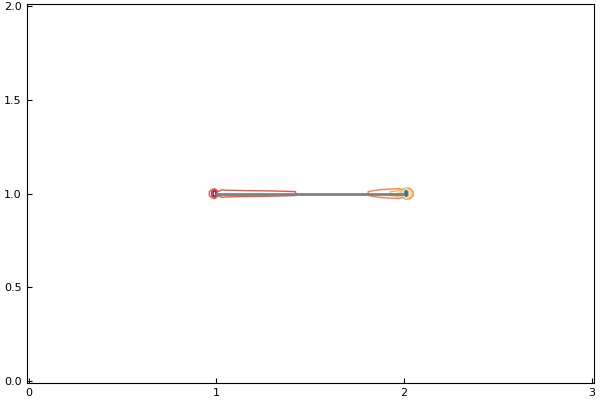

In [26]:
p = plot(xg,yg,w₀)
for i = 1:bd.sys.nbody
    plot!(p,vshist[i,2:3,1], vshist[i,2:3,2],linewidth=2,linecolor="grey")
end
p

In [27]:
w₀[50:100,51]

51-element Array{Float64,1}:
 -1.44245 
 -5.34774 
 -0.967484
 -1.80281 
 -1.44987 
 -1.40859 
 -1.36465 
 -1.30818 
 -1.28653 
 -1.26145 
 -1.24218 
 -1.22436 
 -1.20291 
  ⋮       
  0.203765
  0.31682 
  0.445009
  0.595292
  0.764057
  0.945215
  1.19782 
  1.45173 
  1.66499 
  2.16674 
  2.31128 
  4.0015  